In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import *
import seaborn as sns
import PIL
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
import os
print("tf Version = ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #if use WSL2

tf Version =  2.20.0
Num GPUs Available:  0


In [2]:
batch_size = 10
img_height = 224
img_width = 224
data_dir = 'datasets/chest_xray/'

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # First split: 70% training, 30% for val+test
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
remaining_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # Taking the remaining 30%
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5856 files belonging to 2 classes.
Using 4100 files for training.
Found 5856 files belonging to 2 classes.
Using 1756 files for validation.


In [4]:
val_batches = tf.data.experimental.cardinality(remaining_ds) // 2
test_batches = val_batches
val_ds = remaining_ds.take(val_batches)
test_ds = remaining_ds.skip(val_batches)

In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
print('classname: ',class_names)
print('class: ',num_classes)

classname:  ['NORMAL', 'PNEUMONIA']
class:  2


(10, 224, 224, 3)
(10,)


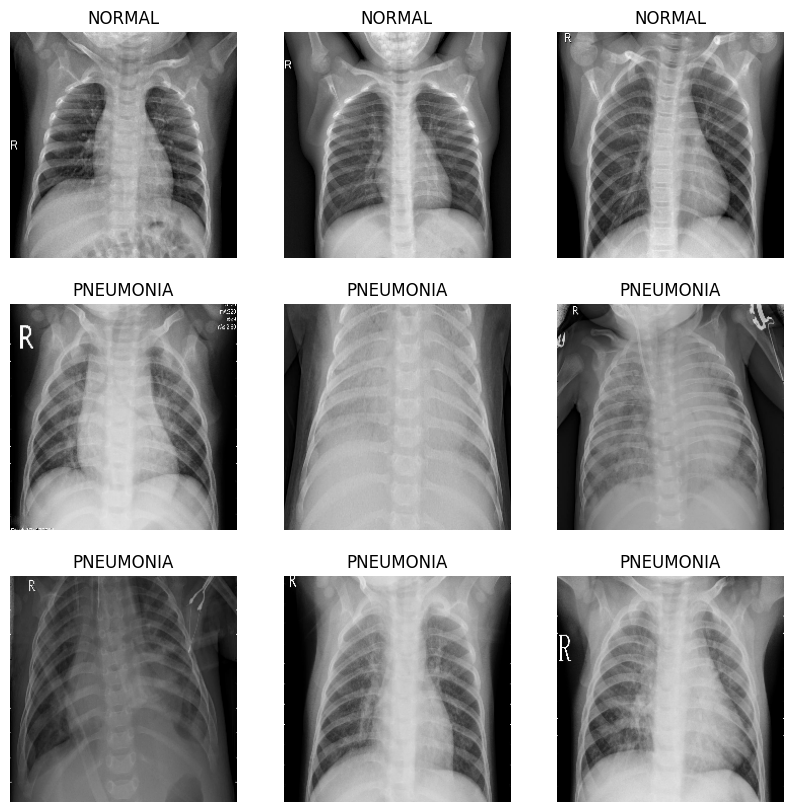

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

print("🔄 preparing dataset...")

# Optimize pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ตรวจสอบค่า pixel ก่อน normalize
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
max_pixel = np.max(first_image)

print(f"ค่า pixel ก่อน normalize: min={np.min(first_image):.6f}, max={max_pixel:.6f}")

# Normalize
if max_pixel > 1.0:
    print("📊 Normalization...")
    normalization_layer = layers.Rescaling(1./255)
    
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
    
    # ตรวจสอบค่าหลัง normalize
    image_batch, labels_batch = next(iter(train_ds))
    print(f"✅ Normalize success: min={np.min(image_batch[0]):.6f}, max={np.max(image_batch[0]):.6f}")
else:
    print("⚠️ The dataset is already normalize")

🔄 preparing dataset...
ค่า pixel ก่อน normalize: min=1.933377, max=254.821442
📊 Normalization...
✅ Normalize success: min=0.000000, max=0.999730


#### Available Models

| Model                | Size (MB) | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth | CPU Time (ms) | GPU Time (ms) |
|----------------------|----------|---------------|---------------|------------|-------|--------------|--------------|
| Xception            | 88       | 79.0%         | 94.5%         | 22.9M      | 81    | 109.4        | 8.1          |
| VGG16               | 528      | 71.3%         | 90.1%         | 138.4M     | 16    | 69.5         | 4.2          |
| VGG19               | 549      | 71.3%         | 90.0%         | 143.7M     | 19    | 84.8         | 4.4          |
| ResNet50            | 98       | 74.9%         | 92.1%         | 25.6M      | 107   | 58.2         | 4.6          |
| ResNet50V2         | 98       | 76.0%         | 93.0%         | 25.6M      | 103   | 45.6         | 4.4          |
| ResNet101          | 171      | 76.4%         | 92.8%         | 44.7M      | 209   | 89.6         | 5.2          |
| ResNet101V2        | 171      | 77.2%         | 93.8%         | 44.7M      | 205   | 72.7         | 5.4          |
| ResNet152          | 232      | 76.6%         | 93.1%         | 60.4M      | 311   | 127.4        | 6.5          |
| ResNet152V2        | 232      | 78.0%         | 94.2%         | 60.4M      | 307   | 107.5        | 6.6          |
| InceptionV3        | 92       | 77.9%         | 93.7%         | 23.9M      | 189   | 42.2         | 6.9          |
| InceptionResNetV2  | 215      | 80.3%         | 95.3%         | 55.9M      | 449   | 130.2        | 10.0         |
| MobileNet          | 16       | 70.4%         | 89.5%         | 4.3M       | 55    | 22.6         | 3.4          |
| MobileNetV2        | 14       | 71.3%         | 90.1%         | 3.5M       | 105   | 25.9         | 3.8          |
| DenseNet121        | 33       | 75.0%         | 92.3%         | 8.1M       | 242   | 77.1         | 5.4          |
| DenseNet169        | 57       | 76.2%         | 93.2%         | 14.3M      | 338   | 96.4         | 6.3          |
| DenseNet201        | 80       | 77.3%         | 93.6%         | 20.2M      | 402   | 127.2        | 6.7          |
| NASNetMobile       | 23       | 74.4%         | 91.9%         | 5.3M       | 389   | 27.0         | 6.7          |
| NASNetLarge        | 343      | 82.5%         | 96.0%         | 88.9M      | 533   | 344.5        | 20.0         |
| EfficientNetB0     | 29       | 77.1%         | 93.3%         | 5.3M       | 132   | 46.0         | 4.9          |
| EfficientNetB1     | 31       | 79.1%         | 94.4%         | 7.9M       | 186   | 60.2         | 5.6          |
| EfficientNetB2     | 36       | 80.1%         | 94.9%         | 9.2M       | 186   | 80.8         | 6.5          |
| EfficientNetB3     | 48       | 81.6%         | 95.7%         | 12.3M      | 210   | 140.0        | 8.8          |
| EfficientNetB4     | 75       | 82.9%         | 96.4%         | 19.5M      | 258   | 308.3        | 15.1         |
| EfficientNetB5     | 118      | 83.6%         | 96.7%         | 30.6M      | 312   | 579.2        | 25.3         |
| EfficientNetB6     | 166      | 84.0%         | 96.8%         | 43.3M      | 360   | 958.1        | 40.4         |
| EfficientNetB7     | 256      | 84.3%         | 97.0%         | 66.7M      | 438   | 1578.9       | 61.6         |
| ConvNeXtTiny      | 109.42   | 81.3%         | -             | 28.6M      | -     | -            | -            |
| ConvNeXtSmall     | 192.29   | 82.3%         | -             | 50.2M      | -     | -            | -            |
| ConvNeXtBase      | 338.58   | 85.3%         | -             | 88.5M      | -     | -            | -            |
| ConvNeXtLarge     | 755.07   | 86.3%         | -             | 197.7M     | -     | -            | -            |
| ConvNeXtXLarge    | 1310     | 86.7%         | -             | 350.1M     | -     | -            | -            |


In [11]:
tf.keras.backend.clear_session()

# จำนวนคลาสในงานจำแนกประเภท
num_classes = len(class_names)

# สร้าง input layer สำหรับรูปภาพขนาด (img_height, img_width, 3)
inputs = Input(shape=(img_height, img_width, 3))

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
], name="data_augmentation")

x = data_augmentation(inputs)
base_model = DenseNet121(
    weights='imagenet', #ใช้ 'imagenet' ถ้าอยากใช้ Pretrainmodel ใช้ None ถ้าจะเทรนใหม่ทั้งหมด
    include_top=False, 
    input_tensor=inputs) 
base_model.trainable = True

# Freeze early layers, unfreeze later layers
for layer in base_model.layers[:-2]:
    layer.trainable = False

x = base_model.output

# เพิ่ม custom layers

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# สร้างโมเดลโดยกำหนด inputs และ outputs
model = Model(inputs=base_model.input, outputs=outputs)


# คอมไพล์โมเดล
model.compile(
    optimizer=AdamW(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ตรวจสอบโครงสร้าง
print("Model output shape:", model.output_shape)
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Model output shape: (None, 2)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,337,058 (27.99 MB)

 Trainable params: 301,538 (1.15 MB)

 Non-trainable params: 7,035,520 (26.84 MB)

In [ ]:
model_save_path = 'models/DenseNet121_chest_xray_20.keras'

epochs = 20
checkpoint = ModelCheckpoint(
    filepath=model_save_path,  # ตำแหน่งไฟล์
    monitor='val_loss',       # เมตริกที่ใช้ในการตรวจสอบ (เช่น val_loss หรือ val_accuracy)
    save_best_only=True,      # บันทึกเฉพาะโมเดลที่ดีที่สุด
    save_weights_only=False,  # บันทึกทั้งโมเดล (ไม่ใช่แค่ weights)
    mode='min',               # เลือกโมเดลที่มีค่าต่ำสุดสำหรับ val_loss
    verbose=1,                 # แสดงข้อความเมื่อบันทึก
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = [
    checkpoint,
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1,
        min_delta=0.001,
    )
]
)

Epoch 1/20
 45/410 ━━━━━━━━━━━━━━━━━━━━ 5:16 867ms/step - accuracy: 0.4580 - loss: 1.3250

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_accuracy:.4f}")

In [ ]:
model_name = os.path.splitext(os.path.basename(model_save_path))[0]  # ดึงชื่อไฟล์โดยไม่มีนามสกุล
output_dir = os.path.join('validpic', model_name)
os.makedirs(output_dir, exist_ok=True)

# ========== 1. Training vs Validation Accuracy/Loss ==========
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig(os.path.join(output_dir, 'training_vs_validation.png'))
plt.show()

# ========== 2. Predict และเตรียมข้อมูลสำหรับ evaluation (ทำครั้งเดียว) ==========
# หมายเหตุ: ย้าย prediction มาไว้ที่เดียว เพื่อไม่ให้ predict ซ้ำ
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# ========== 3. Confusion Matrix ==========
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

# ========== 4. Precision-Recall Curve ==========
# หมายเหตุ: แก้ไข logic - ใช้ y_pred (probability) แทน y_pred_classes
precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2, 
             label=f'{class_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(output_dir, 'precision_recall_curve.png'))
plt.show()

# ========== 5. F1 Score vs Threshold Curve ==========
y_pred_proba = np.max(y_pred, axis=1)      # ค่าความมั่นใจสูงสุด
y_pred_label = np.argmax(y_pred, axis=1)   # class ที่ predict

# สร้าง threshold values จาก 0 ถึง 1
thresholds = np.linspace(0, 1, 101)  # 101 จุด จาก 0.00 ถึง 1.00
f1_scores = []

for t in thresholds:
    # กรอง samples ที่มี confidence >= threshold
    valid_idx = y_pred_proba >= t
    
    # หมายเหตุ: ถ้าไม่มี sample ใดที่ผ่าน threshold ให้ใส่ F1 = 0
    if valid_idx.sum() == 0:
        f1_scores.append(0.0)
    else:
        # คำนวณ F1 score เฉพาะ samples ที่ผ่าน threshold
        f1_t = f1_score(y_true[valid_idx], y_pred_label[valid_idx], 
                        average="weighted", zero_division=0)
        f1_scores.append(f1_t)

plt.figure(figsize=(10, 8))
plt.plot(thresholds, f1_scores, lw=2, label="F1 Score (weighted)")
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Confidence Threshold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(output_dir, 'f1_curve.png'))
plt.show()

print(f"\n All plots saved to: {output_dir}/")
print(f"   - training_vs_validation.png")
print(f"   - confusion_matrix.png")
print(f"   - precision_recall_curve.png")
print(f"   - f1_curve.png")